Temporal QA checks. See the results for prediction on the same location multiple times over the course of 4 weeks.

Before this notebook can be run:
1. Run notebook 1.0 to generate `experiments/results/temporal_qa_checks/samples.csv`
2. Run `python cyano/cli.py predict experiments/results/temporal_qa_checks/samples.csv --output-path experiments/results/temporal_qa_checks/preds.csv` to generate predictions

In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

from cyano.data.utils import add_unique_identifier

In [3]:
EXPERIMENT_DIR = Path("../experiments/results/temporal_qa_checks")

In [8]:
true = pd.read_csv(EXPERIMENT_DIR / "samples.csv")
true = add_unique_identifier(true)
print(true.shape)
true.head()

(160, 5)


,latitude,longitude,date,region,original_sample_id
sample_id,,,,,
bd5f4cf826f661240e2e2492a94f0fa3,36.5,-79.066285,2019-05-14,south,62e60b0aaa2e7df569988355e48a40b0
38411816870a10c4bf6347ef7b5790ee,36.5,-79.066285,2019-05-21,south,62e60b0aaa2e7df569988355e48a40b0
03b6a9b387cb12b74f337ce426551eea,36.5,-79.066285,2019-05-28,south,62e60b0aaa2e7df569988355e48a40b0
27eee4293de9e00ce9ef516016ec035f,36.5,-79.066285,2019-06-04,south,62e60b0aaa2e7df569988355e48a40b0
c70182bde7b5486add505e7b0edb7004,36.5,-79.066285,2019-06-11,south,62e60b0aaa2e7df569988355e48a40b0


In [9]:
preds = pd.read_csv(EXPERIMENT_DIR / "preds.csv")

preds = preds.sort_values(by=["latitude", "longitude", "date"])
preds["original_sample_id"] = true.loc[preds.sample_id].original_sample_id.values
preds["region"] = true.loc[preds.sample_id].region.values

# add actual predicted density
preds["density"] = np.exp(preds.log_density) - 1

print(preds.shape)
preds.head()

(160, 9)


,sample_id,date,latitude,longitude,log_density,severity,original_sample_id,region,density
15,5b563c4d5db0c024950ec072a65f5bff,2017-08-02,32.04151,-91.99869,10.444166,2.0,34e9afba3e0d180bcd3d08deb3c0ba92,south,34342.436992
16,b7d83342758aab09716f33f2bf66b5e6,2017-08-09,32.04151,-91.99869,10.467774,2.0,34e9afba3e0d180bcd3d08deb3c0ba92,south,35162.838453
17,8dbc9f9751806f2ddb74772dbdc98d09,2017-08-16,32.04151,-91.99869,11.110680,2.0,34e9afba3e0d180bcd3d08deb3c0ba92,south,66880.661511
18,abc3084d081864b9081b1a6d50869c32,2017-08-23,32.04151,-91.99869,10.737413,2.0,34e9afba3e0d180bcd3d08deb3c0ba92,south,46045.755877
19,3ac9cc16a37eda7396802900d2de4438,2017-08-30,32.04151,-91.99869,11.699831,3.0,34e9afba3e0d180bcd3d08deb3c0ba92,south,120550.391861


### Process prediction data

In [10]:
preds.isna().sum()

sample_id              0
date                   0
latitude               0
longitude              0
log_density           21
severity              21
original_sample_id     0
region                 0
density               21
dtype: int64

In [11]:
# drop rows with no prediction
preds = preds[preds.log_density.notna()]
preds.isna().sum().sum()

0

In [18]:
# how many locations do we have?
preds[["latitude", "longitude"]].drop_duplicates().shape

(24, 2)

In [12]:
# how many original samples?
preds.original_sample_id.nunique()

28

In [14]:
# add cumulative stats so we can identify the date order of samples within a location
def _add_cumulative_stats(sub_df):
    sub_df["week_at_location"] = range(len(sub_df))

    sub_df["change"] = sub_df.density.diff()
    sub_df["abs_pct_change"] = np.abs(sub_df.density.diff() / sub_df.density.shift(1))

    sub_df["change_log"] = sub_df.log_density.diff()
    sub_df["abs_pct_change_log"] = np.abs(
        sub_df.log_density.diff() / sub_df.log_density.shift(1)
    )

    return sub_df


preds = (
    preds.groupby(["original_sample_id"])
    .apply(_add_cumulative_stats)
    .reset_index(drop=True)
)

In [16]:
preds.head(10)[
    [
        "date",
        "latitude",
        "longitude",
        "log_density",
        "density",
        "change",
        "abs_pct_change",
        "week_at_location",
    ]
]

,date,latitude,longitude,log_density,density,change,abs_pct_change,week_at_location
0,2017-08-08,32.78670,-116.7818,11.063040,63769.108745,NaN,NaN,0
1,2017-08-15,32.78670,-116.7818,11.274520,78787.312937,15018.204193,0.235509,1
2,2017-08-22,32.78670,-116.7818,11.323471,82740.045351,3952.732414,0.050170,2
3,2017-08-29,32.78670,-116.7818,11.109582,66807.240096,-15932.805256,0.192565,3
4,2017-09-05,32.78670,-116.7818,11.360151,85831.314425,19024.074330,0.284761,4
5,2017-07-25,33.83376,-84.0932,11.282314,79403.785049,NaN,NaN,0
6,2017-08-01,33.83376,-84.0932,10.788649,48466.496892,-30937.288157,0.389620,1
7,2017-08-08,33.83376,-84.0932,10.831821,50604.773508,2138.276616,0.044119,2
8,2017-08-15,33.83376,-84.0932,11.328287,83139.484695,32534.711187,0.642918,3
9,2017-08-22,33.83376,-84.0932,11.140147,68880.777855,-14258.706840,0.171503,4


### Evaluate

**What is the percent change between dates at the same location?**

- Most are pretty small in log densities. In 75% of cases, the predicted log density changes by less than 6% between weeks
- With absolute density, the percent change runs the gamut and is large in some cases. It is still generally not huge -- in half of cases, the predicted exact density changes by less than ~30% between weeks.

In [18]:
preds.filter(regex="change").describe()

,change,abs_pct_change,change_log,abs_pct_change_log
count,1.110000e+02,111.000000,111.000000,111.000000
mean,-1.963076e+03,0.490845,0.057740,0.040419
std,2.013363e+05,0.552055,0.569685,0.035737
min,-1.060654e+06,0.000077,-1.619243,0.000007
25%,-9.392073e+03,0.138726,-0.255490,0.013246
50%,8.204015e+02,0.312216,0.043172,0.029056
75%,1.154220e+04,0.632814,0.404111,0.059026
max,1.020781e+06,2.715815,1.312568,0.156159


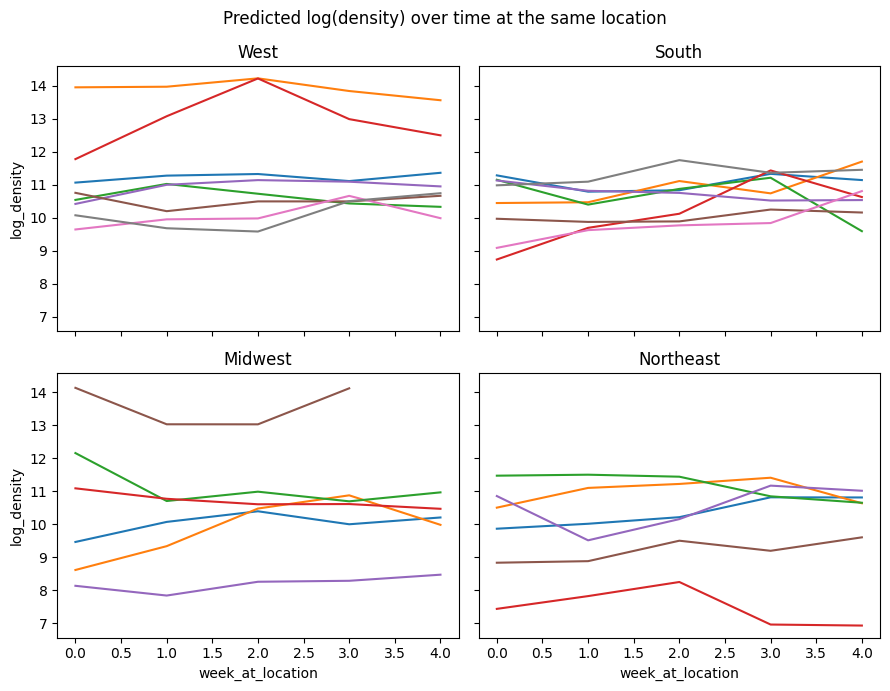

In [19]:
# See log density over time by region
_, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 7))

for region, ax in zip(preds.region.unique(), axes.flatten()):
    sns.lineplot(
        data=preds[preds.region == region],
        x="week_at_location",
        y="log_density",
        hue="original_sample_id",
        legend=False,
        ax=ax,
    )
    ax.set_title(region.capitalize())

plt.suptitle("Predicted log(density) over time at the same location")
plt.tight_layout()

Log density is fairly consistent at each location and doesn't wildly oscillate.

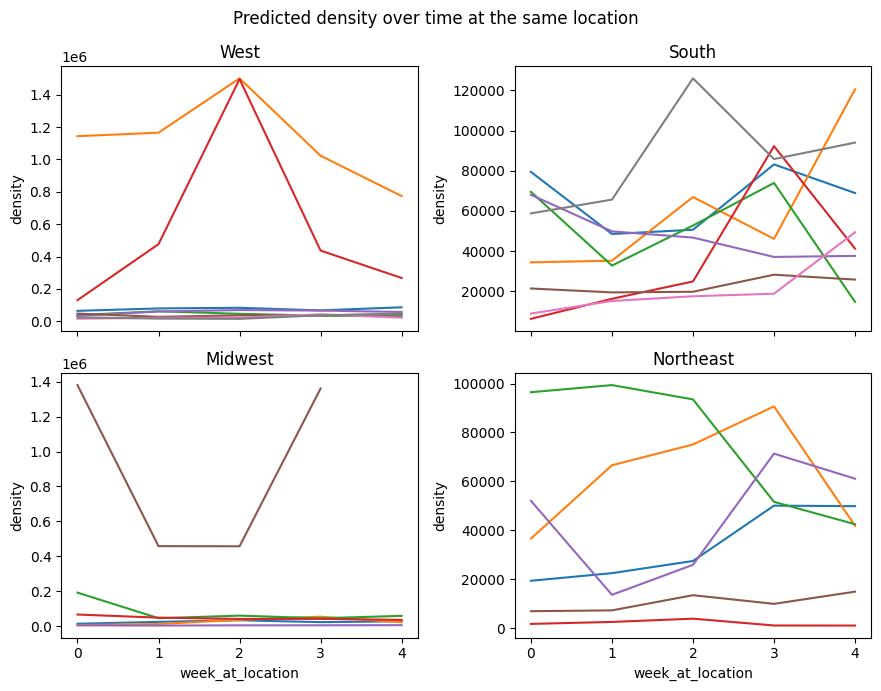

In [20]:
# See density over time by region
_, axes = plt.subplots(2, 2, sharex=True, figsize=(9, 7))

for region, ax in zip(preds.region.unique(), axes.flatten()):
    sns.lineplot(
        data=preds[preds.region == region],
        x="week_at_location",
        y="density",
        hue="original_sample_id",
        legend=False,
        ax=ax,
    )
    ax.set_title(region.capitalize())

plt.suptitle("Predicted density over time at the same location")
plt.tight_layout()

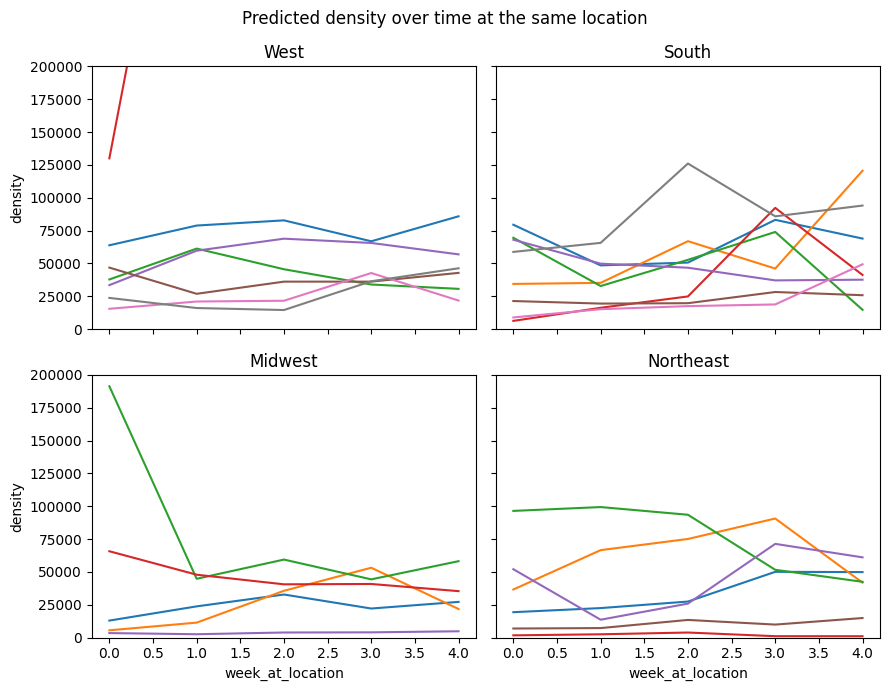

In [21]:
# same as above but with a more reasonable scale
_, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 7))

for region, ax in zip(preds.region.unique(), axes.flatten()):
    sns.lineplot(
        data=preds[preds.region == region],
        x="week_at_location",
        y="density",
        hue="original_sample_id",
        legend=False,
        ax=ax,
    )
    ax.set_title(region.capitalize())
    ax.set_ylim([0, 2e5])

plt.suptitle("Predicted density over time at the same location")
plt.tight_layout()

For exact density, larger swings are more common. However, we do still generally see relative consistency over time.

In [22]:
# what is the severity level range at one location over time?
severity_range = preds.groupby("original_sample_id").agg(
    min_severity=("severity", "min"),
    max_severity=("severity", "max"),
)
severity_range["severity_range"] = (
    severity_range.max_severity - severity_range.min_severity
)
severity_range.severity_range.value_counts().sort_index()

severity_range
0.0    12
1.0    16
Name: count, dtype: int64

No sample changes by more than one severity level over time.

In [23]:
severity_range.groupby(["min_severity", "max_severity"]).size().rename(
    "count"
).sort_index().to_frame()

count
min_severity max_severity       
1.0          1.0               3
             2.0              10
2.0          2.0               9
             3.0               3
3.0          4.0               3